# Calculating coordinates for hangers 

The goal of this notebook is to provide a method for calculating the coordinates of hanger placement, for automatic drilling.  

We will base the example script on an IFC file of a ventilation system modelled in Magicad For Revit 2014.4, and parameters as given by a company using the drilling robot. 

We will be using the following file:

> Ventilation file: 12A-AmbS-RIV-141223-1328-Ambulanse ventilasjon3.ifc

Further we could extend the script by checking the corresponding Prefab file that holds the Hollow Core slabs that the hangers will be mounted in. There are rules in where one could drill a hole in a hollow core slab. This is an optional challenge. This is the file to be used for that:

> Prefabrication file: 12A-Ambs-RIBprf-150508-1550.ifc

The models are presented in the image below. 
![Image presenting the models](images/models.png "Visualization of models")

In [1]:
# Start by importing libraries you at least need one in additon to numpy
import numpy as np

# Open the file and store it in f_vent
f_vent = 



## Parameters provided by nLink

Explanation of parameters are set to guide the calculation


In [2]:
# Parameters

# Category of elements to filter 
elem_type_to_filter = "IfcFlowSegment"
# Minimum length (mm) without hanger 
min_len_without = 600 
# Offset start and end of segment in mm 
offset = 100; 
# Minimum length (mm) with 1 hanger in center
min_len_hanger_center = 500 
# Max length (mm) with 1 hanger in center
max_len_hanger_center = 1400
# max length (mm) between hangers 
max_len_between = 2000

# Min diametre (mm) for double hangers
min_diam = 400;

## Only horizontal elements are given hangers. 

In [3]:
# Start by exploring the number of elements to filter out we have in the model (hint: elem_type_to_filter)
# store it in the elems variable 
elems = 
# print out the number of elements - should read 49


49


### This script will depend on the representation of elemens

The IfcFlowSegment is a IfcProduct, and thus it has both *ObjectPlacement* and *Representation* attributes. 

*ObjectPlacement* as described in 9.1.2 Concept of object placement of [IFC Implementers guide](https://standards.buildingsmart.org/documents/Implementation/IFC2x_Model_Implementation_Guide_V2-0b.pdf) is by default relative. This means that a IfcFlowSegment is relative to its IfcBuildingStorey. ObjectPlacement gives the "object coordinate system" from which its shape *Representation* is described. 

There are several ways of describing a shape of the products within IFC, as chapter 9 in the IFC Implementers guide describes. As seen below the IfcShapeRepresentation is of type "MappedRepresentation": 

>representation based on mapped item(s), referring to a representation map. Note: it can be seen as an inserted block reference. The shape representation of the mapped item has a representation type declaring the type of its representation items.

In order to build robustness into this script for handeling all posible cases, you would need to check and verify that ObjectPlacement is relative and that the ShapeRepresentation is of MappedRepresentation. Further it would be needed to provide different logic depending on the checks. Eg. Different ShapeRepresentations would need different ways of deriving the neccessary information for calculating the coordinates for hangers. 

In [4]:
# The representation is of a MappedRepresentation type
shape_rep=elems[2].Representation.Representations[0]
shape_rep

#14162=IfcShapeRepresentation(#73351,'Body','MappedRepresentation',(#14160))

The shape representation that is mapped to all the elements is of type "SweptSolid":
> 	swept area solids, by extrusion and revolution

This shape repersentation holds a reference to representation items of type [IfcExtrudedAreaSolid](http://www.buildingsmart-tech.org/ifc/IFC2x3/TC1/html/ifcgeometricmodelresource/lexical/ifcextrudedareasolid.htm)

>The extruded area solid (IfcExtrudedAreaSolid) is defined by sweeping a bounded planar surface. The direction of the extrusion is given by the ExtrudedDirection attribute and the length of the extrusion is given by the Depth attribute. If the planar area has inner boundaries, i.e. holes defined, then those holes shall be swept into holes of the solid.

![Illustration](images/illustration ifcextrudedareasolid.png "IfcExtrudedAreaSolid")

The following inheritance graph: 

![Illustration](images/inheritance graph.png "Inheritance graph")

In [6]:
""" The following are helper functions that are created to help with some math and tests. If you test with another model, 
having other geometry or something it might need modification.

Most of the code is matrix calulation to handle the relative coorination systems. 
Use the IFC documentation to help the understanding"""

# Get position data on a a IfcAxis2Placement3D element 
# Code from Thomas Krijnen
def a2p(o,z,x):
    y = np.cross(z, x)
    r = np.eye(4)
    r[:-1,:-1] = x,y,z
    r[-1,:-1] = o
    return r.T
# Code from Thomas Krijnen
def axis2placement(plc):
    z = np.array(plc.Axis.DirectionRatios if plc.Axis else (0,0,1))
    x = np.array(plc.RefDirection.DirectionRatios if plc.RefDirection else (1,0,0))
    o = plc.Location.Coordinates
    return a2p(o,z,x)

# Helper functions
# Travers relative position till absolute, and return list of IfcAxis2Placement3D for respective elements
def get_rel_structure(elem):
    place = elem.ObjectPlacement
    list_of_rel = []
    while True:
        if place.PlacementRelTo is None:
            # if this location is absolutely placed in world coordinate system of geometric representation context
            list_of_rel.append(place.RelativePlacement)
            # prints out the object type that is being placed by current "place" variable
            #print(place.PlacesObject[0].is_a())
            break
        else:
            # if this location is stil relative to another location store, and continue traversal
            list_of_rel.append(place.RelativePlacement)
            # add the relative place to place for a new iteration. 
            place = place.PlacementRelTo
    # returns a list of all the axis2placements hiearchically
    return list_of_rel

# Get the axis2placement3D from Representation for SwepSolid type ExtrudedAreaSolid item
#Helper function to get the representation of an element that has a mapped representation
def get_mapped_representation_of(elem):
    shape_rep = [shape_rep for shape_rep in elem.Representation.Representations
                 if shape_rep.RepresentationType=="MappedRepresentation"]
    if shape_rep:
        return shape_rep[0].Items[0].MappingSource.MappedRepresentation
    else:
        return None

# Get Extruded area solid for a Mapped (or not Mapped) SweptSolid type of representation. 
def get_rep_a2p(elem):
    mapped_rep = get_mapped_representation_of(elem)
    if mapped_rep:
        ss_rep =  mapped_rep if mapped_rep.RepresentationType=='SweptSolid'else None
        rep_item = [repr_item for repr_item in ss_rep.Items if repr_item.is_a("IfcExtrudedAreaSolid")][0]
        return rep_item
    else:
        ss_rep = [representation for representation 
                           in elem.Representation.Representations 
                           if representation.RepresentationType=='SweptSolid'][0]
        rep_item = [repr_item for repr_item in ss_rep.Items if repr_item.is_a("IfcExtrudedAreaSolid")][0]
        return rep_item
        
# Get a point expressed in a length from the representation coordinate system
def get_point_along_extr(rep_item,length):
    extr_dir = np.asarray(rep_item.ExtrudedDirection.DirectionRatios)
    depth = rep_item.Depth
    if float(length) <= depth:
        return extr_dir*float(length)
    else:
        print ("length out of range, element length is: ",depth)

# Get absolute coordinates of a point on a given length from incertion point along the extrusion length of a element        
def get_abs_coordinates_of_point_on_elem_by_len(elem,length):
    rep_item = get_rep_a2p(elem)
    pos=rep_item.Position
    point = get_point_along_extr(rep_item,length)
    structure = get_rel_structure(elem)
    for i in range(len(structure)):
        point = transform_to_parent_base(pos,point)
        pos = structure[i]
    return(point)

# Transform a point in a coordinate system expressed in coordinate system it's relative to
def transform_to_parent_base(a2p,point):
    a2p = axis2placement(a2p)
    M = a2p[:-1,:-1]
    o = a2p[:-1,-1]
    
    return o + np.dot(M,point)

# helper function to check if element is circular
def is_circular(elem):
    profile = get_rep_a2p(elem).SweptArea
    if profile.is_a("IfcCircleHollowProfileDef"):
        return True
    else:
        return False
    
# Helper function to check if element is horizontal
# Assumes rotation of element is handled between the relative rotation between ObjectPlacement and its parent
# Assumes ref direction for horizontal tube have ortagonality with parent Z axis
def is_horizontal(elem):
    obj_a2p = axis2placement(elem.ObjectPlacement.RelativePlacement)[:-1,1]

    parent_a2p = axis2placement(elem.ObjectPlacement.PlacementRelTo.RelativePlacement)[:-1,-2]

    if np.dot(obj_a2p,parent_a2p) == 0:
        return True
    else:
        return False

# helper function to get radius of an element with a circular profil def
def get_radius(elem):
    if is_circular(elem):
        return get_rep_a2p(elem).SweptArea.Radius
    else:
        return None

# Get element length
def get_length(elem):
    return get_rep_a2p(elem).Depth
def get_relating_storey(elem):
    relatingStructure = elem.ContainedInStructure[0].RelatingStructure
    if relatingStructure.is_a("IfcBuildingStorey"):
        return relatingStructure
    else:
        return "Not directly confined in a storey"

In [ ]:
## Feel free to use these cells to test out some of the functions 

In [ ]:
## Feel free to use these cells to test out some of the functions 

# Main Exercise
Complete the exersice below. 

In [7]:
# Filter away all non-horizontal elements, and chose only get circular ones, and store it in h_elems 
h_elems = 
# Do not change below - should read 38
print("Number of elemens:",len(h_elems))

Number of elemens: 38


In [8]:
# Filter away tubes less than min length, and store the rest in h_elems again
h_elems = 
# Do not change below - should read 14
print("Number of elemens:",len(h_elems))

Number of elemens: 14


In [9]:
# Filter elements with hanger in center, and store them in ch_elems
ch_elems =

# Do not change below: Should read 6
print("Number of elemens:",len(ch_elems))

Number of elemens: 6


In [11]:
# Loop through all ch_elems and print each elements length - should be 827.0, 633.0, 1113.0, 675.0, 796.0, 773.0


827.0
633.0
1113.0
675.0
796.0
773.0


In [13]:
# Filter elemens of h_elems that needs hangers placed according to ofset and max hanger distance and store them in other_elems
other_elems = 

# Do not change below, should read 8 
print("Number of elemens:",len(other_elems))

Number of elemens: 8


In [15]:
# Loop through all other_elems and print each elements length - should read 1887.0, 2535.0, 6025.0, 1720.0, 2785.0, 
# 4184.0, 2156.0, 4412.0


1887.0
2535.0
6025.0
1720.0
2785.0
4184.0
2156.0
4412.0


In [17]:
# Helper routine for getting hanger data for a length measure along the element
def get_data_row(elem,length):
    row = []
    row.append(get_relating_storey(elem).Name)
    row.append(elem.GlobalId)
    coords=get_abs_coordinates_of_point_on_elem_by_len(elem,length)
    row.append(coords[0])
    row.append(coords[1])
    row.append(coords[2])
    return row

In [19]:
# get coordinates for elemens with hanger in center 
# Initiate a list called data
data = 
# loop through all elemens in ch_elems 
for elem in ch_elems:
    # Find the length to the center of the element and store it in "center"
    center = 
    # Use the get_data_row function above to get the row of data and append it to the data list. 
    data

# Get coordinates according to max length between hangers.
# loop through all elements in other_elems
for elem in other_elems:
    # store the elements length in length
    length = 
    # store the offset from edges in len_to_hang
    len_to_hang = 
    # Use the get_data_row function above and append the first coordinate on the edge in the data list
    data
    # don't change the rest of the code in this cell. 
    # Walk over the length of the element to get the rest of the coordinates. 
    while (length-len_to_hang-offset) > max_len_between:
        # gets the length 
        len_to_hang = len_to_hang + max_len_between
        # gets and appends the coordinate in the data list
        data.append(get_data_row(elem,len_to_hang))
    
    # Use the get_data_row function above and append the first coordinate on the end edge in the data list
    data.append(get_data_row(elem,length-offset))

### Plot coordinates on xy plane 

## Top view of RIV file
![Image presenting the top view of riv](images/top view riv.png "Top View of RIV model")


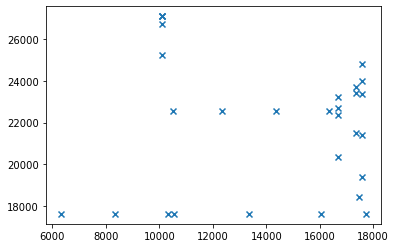

In [24]:
# Store data in pandas dataframe and plot in X Y plane
# Don't change the below code. 

## Note; the fillowing line does some command line magic in notebook, to install the pandas module on the system. 
## Feel free to comment it out after you have run it ones. 
!pip install pandas
import pandas as pd
df = pd.DataFrame(data,columns = ["Storey","GUID","X","Y","Z"])
import matplotlib.pyplot as plt
plt.scatter(df["X"],df["Y"], marker='x')
plt.show()

In [22]:
# Run this cell to look at the first 5 rows of the data frame. 
df.head()

,Storey,GUID,X,Y,Z
0,1. etasje,3sCDLgQfXDPwrpyDWCLpeV,17482.19060,18428.032050,3335.000000
1,1. etasje,25xF2VUGb41AoUT9DWpblJ,17560.50267,24810.343250,2500.000000
2,1. etasje,25xF2VUGb41AoUT9DWpcO_,17560.50267,23987.201114,2940.367966
3,1. etasje,25xF2VUGb41AoUT9DWpcP8,17338.69060,23700.207330,2837.500000
4,1. etasje,25xF2VUGb41AoUT9DWpd2e,16668.69060,23232.017060,3335.000000


In [23]:
# Google pandas to csv and use what you find to store the data as a csv file

df.to_csv("hanger_coordinates.csv")

# Get allowed area for drilling in hollow core slab

the optional section starts here ;-) 

In [ ]:
### Start by asking me for a file, or use your own ;-) 